In [40]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Data Exploration

We'll start by loading the data files and try to identify the necessary transformations for our models

In [15]:
import calendar
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
data_files = glob.glob("./data/*.csv")
data_files

['./data/aisles.csv',
 './data/departments.csv',
 './data/order_products__prior.csv',
 './data/order_products__train.csv',
 './data/orders.csv',
 './data/products.csv']

In [3]:
aisles_df = pd.read_csv(data_files[0], index_col="aisle_id")
departments_df = pd.read_csv(data_files[1], index_col="department_id")
order_products_prior = pd.read_csv(data_files[2])
orders = pd.read_csv(data_files[4], index_col="order_id")
products = pd.read_csv(data_files[5], index_col="product_id")

In [4]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
orders.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2539329,1,prior,1,2,8,NaN
2398795,1,prior,2,3,7,15.0
473747,1,prior,3,3,12,21.0
2254736,1,prior,4,4,7,29.0
431534,1,prior,5,4,15,28.0


In [6]:
aisles_df.head()

,aisle
aisle_id,
1,prepared soups salads
2,specialty cheeses
3,energy granola bars
4,instant foods
5,marinades meat preparation


In [7]:
departments_df.head()

,department
department_id,
1,frozen
2,other
3,bakery
4,produce
5,alcohol


In [8]:
products.head()

,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13


##### Then let's look at how the data distributions look like

8AM to 6PM is when the bulk of the orders placed

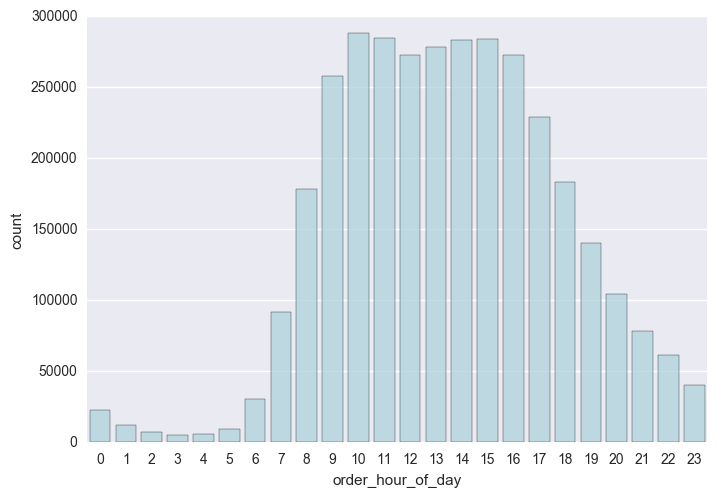

In [32]:
sns.countplot("order_hour_of_day", data=orders, color="lightblue", alpha=.8)
plt.show()

But is this info useful for items getting re-ordered? Let's get the reordered products and see how their distribution looks

In [26]:
re_ordered_products = order_products_prior[order_products_prior["reordered"] == 1]
re_ordered_products["order_time"] = re_ordered_products.order_id.map(orders.order_hour_of_day)
re_ordered_products["order_dow"] = re_ordered_products.order_id.map(orders.order_dow)
re_ordered_products.head()

,order_id,product_id,add_to_cart_order,reordered,order_time,order_dow
0,2,33120,1,1,9,5
1,2,28985,2,1,9,5
3,2,45918,4,1,9,5
5,2,17794,6,1,9,5
6,2,40141,7,1,9,5


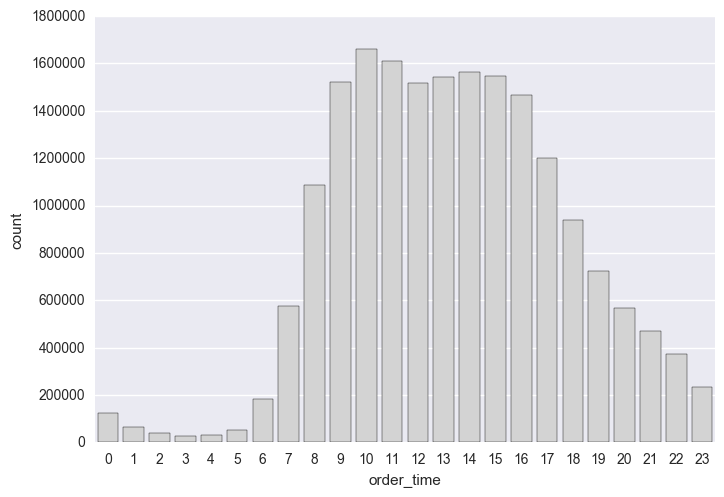

In [10]:
sns.countplot("order_time", data=re_ordered_products, color="lightgray")
plt.show()

So no, not really, the time of the order looks pretty similar to the total of order distribution.

On the other hand, let's see if the order in which the products are added to the cart matters

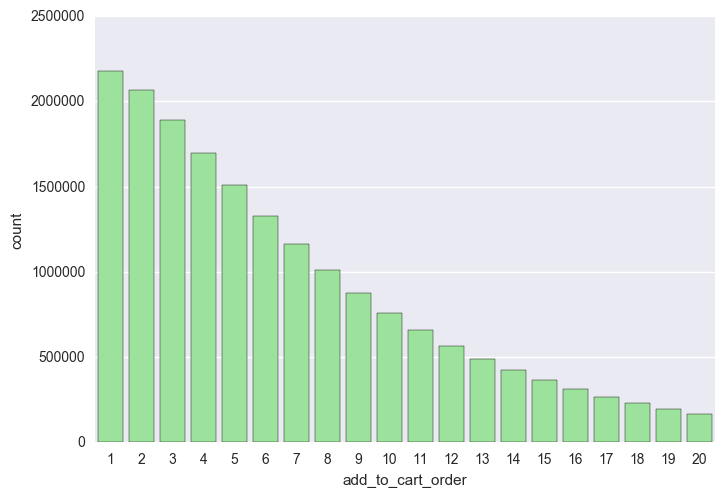

In [14]:
# _ there are outliers in the data
# _ re_ordered_products["add_to_cart_order"].plot(kind="box")
data = re_ordered_products[re_ordered_products["add_to_cart_order"] <= 20]
sns.countplot("add_to_cart_order", data=data, color="lightgreen")
plt.show()

Yes! Seems like the products that get added to the cart are re-ordered more frequently

Next let's take a look how long it normally it takes for a re-order

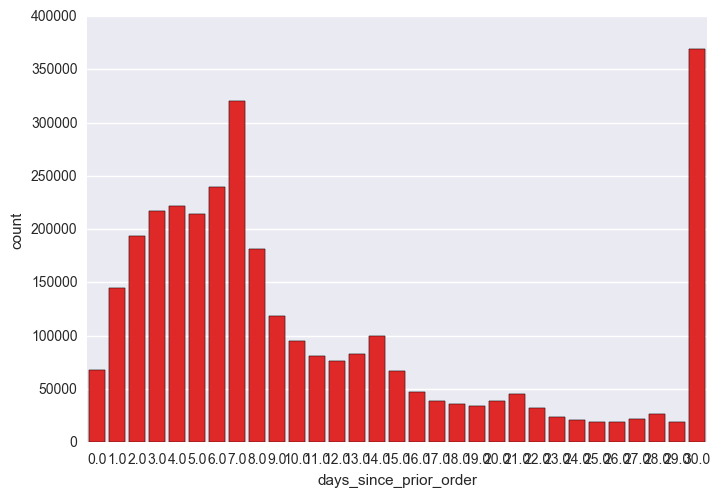

In [39]:
sns.countplot("days_since_prior_order", data=orders, color="red", alpha=.8)
plt.show()

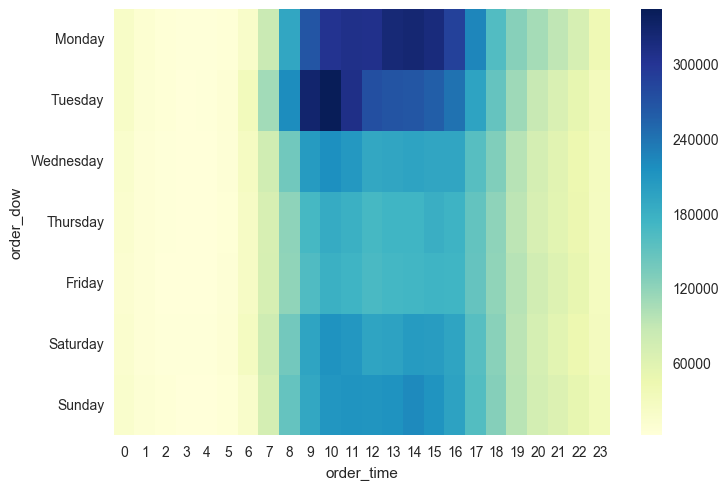

In [35]:
data = re_ordered_products.pivot_table(index="order_dow", columns="order_time", values="product_id", aggfunc=np.count_nonzero)
data.reset_index(inplace=True)
data["order_dow"] = data.order_dow.apply(lambda x: calendar.day_name[x])
data.index = data["order_dow"]
del data["order_dow"]
sns.heatmap(data, cmap="YlGnBu")
plt.show()

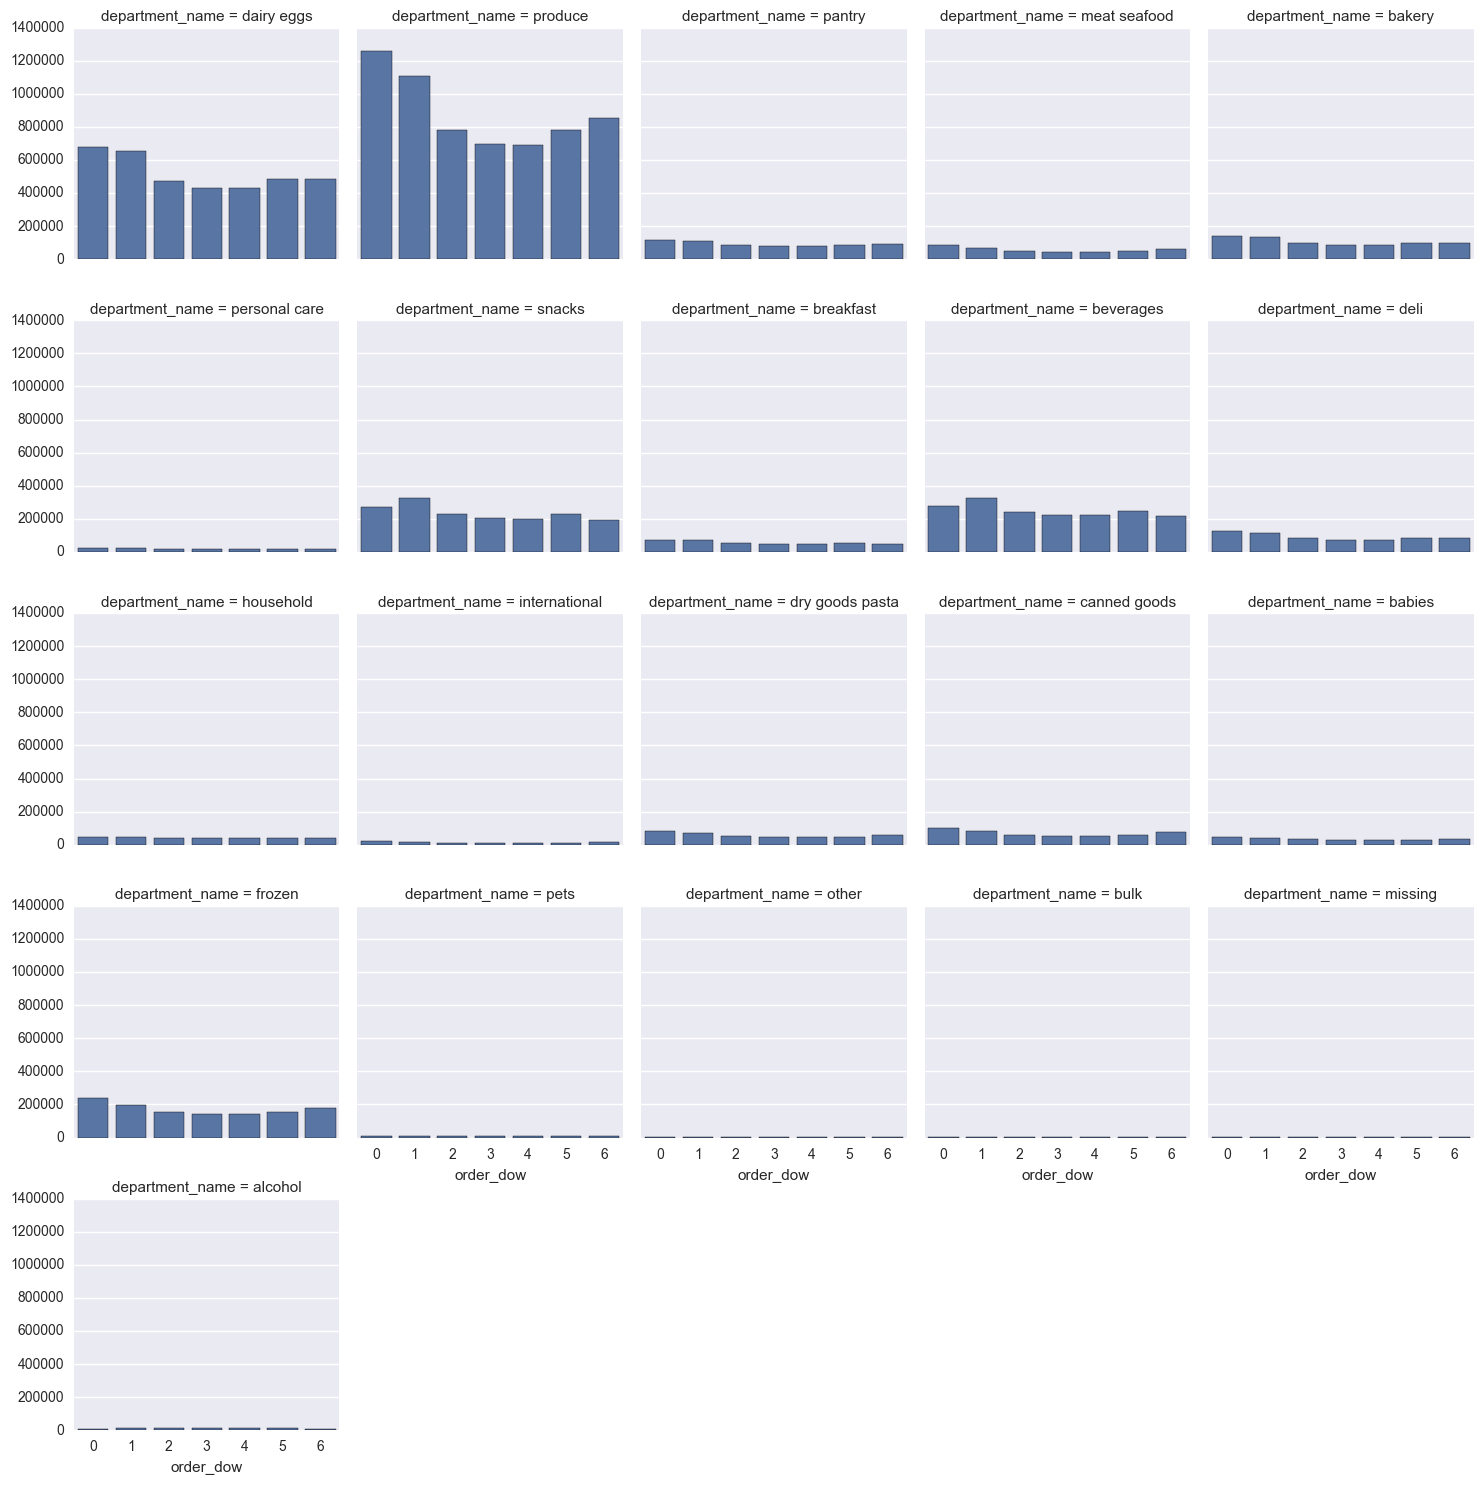

In [63]:
g = sns.FacetGrid(re_ordered_products, col="department_name", col_wrap=5)
g.map(sns.countplot, "order_dow")
plt.show()